In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error as MSE
import sklearn
import sklearn.gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from matplotlib.patches import Rectangle


import os
import warnings
import random
import ucb
import time
import math
import seaborn as sb

In [2]:
def min_max(spectra):
    scaler = sklearn.preprocessing.MinMaxScaler()
    return scaler.fit_transform(spectra.reshape(-1,1)).reshape(1,-1)[0]


def spectra_from_conc(action, RED, GREEN):
    """Transforms actions and input into output."""
    fract = normalize_to_fraction(action)
    spec = RED*action[0] + GREEN*action[1]
    return spec

def normalize_to_fraction(action):
    """Returns the fraction of total volume given the concentrations (action)."""
    total = np.sum(action)
    if total < .0001:
        return action * 0
    return action / total

class Environment(object):
    def __init__(self, target, RED, GREEN, BLUE):
        # in future this will be basis spectra
        self.target = target
        self.RED = RED
        self.GREEN = GREEN
        self.BLUE = BLUE
        self.metric = []
   
    def get_cos_sim(self, target, y):
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def sample(self, action):
        # put functins in utils python file
        result = spectra_from_conc(action, self.RED, self.GREEN)
        sim = self.get_cos_sim(self.target, result)
        mse = MSE(self.target, result)
        self.metric.append(sim)
        #return -mse*100
        return sim

In [ ]:
sample_spectra = pd.read_excel('../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)

In [ ]:
wavelength = sample_spectra[:,0]
# spectra of base dyes
RED = sample_spectra[:,1]
GREEN = sample_spectra[:,2]
BLUE = sample_spectra[:,3]
#target_conc = np.random.dirichlet((1, 1), 1)[0]
target_conc = [.3, .7]
target_spectra = spectra_from_conc(target_conc, RED, GREEN)
target = target_spectra
    
env = Environment(target_spectra, RED, GREEN, BLUE)

batch_size = 4
epochs = 8

In [ ]:
#constraints
min_conc = 0
max_conc = 1

# parameter space
N = 11 # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs)


In [ ]:
kernel = ConstantKernel(.5, constant_value_bounds="fixed") * RBF(.5, length_scale_bounds="fixed")
beta = 5

agent3 = ucb.BatchGPUCBv3(batch_size, param_space, env, beta=beta, kernel = kernel)
agent2 = ucb.BatchGPUCBv2(batch_size, param_space, env, beta=beta, kernel = kernel)
agent1 = ucb.BatchGPUCB(batch_size, param_space, env, beta=beta, kernel = kernel)

In [ ]:
mu1 = [agent1.mu.reshape(len(coeffs),len(coeffs))]
mu2 = [agent2.mu.reshape(len(coeffs),len(coeffs))]
mu3 = [agent3.mu.reshape(len(coeffs),len(coeffs))]

sig1 = [agent1.sigma.reshape(len(coeffs),len(coeffs))]
sig2 = [agent2.sigma.reshape(len(coeffs),len(coeffs))]
sig3 = [agent3.sigma.reshape(len(coeffs),len(coeffs))]

elim = []
locs = []

for i in range(epochs):
    agent1.learn()
    mu1.append(np.flip(agent1.mu.reshape(len(coeffs),len(coeffs)), axis=0))
    sig1.append(np.flip(agent1.sigma.reshape(len(coeffs),len(coeffs)), axis=0))
    agent2.learn()
    mu2.append(np.flip(agent2.mu.reshape(len(coeffs),len(coeffs)), axis=0))
    sig2.append(np.flip(agent2.sigma.reshape(len(coeffs),len(coeffs)), axis=0))
    elim.append(agent3.learn())
    mu3.append(agent3.mu)
    sig3.append(agent3.sigma)
    locs.append(agent3.X_grid)

In [ ]:
print(locs[2])

In [ ]:
print(mu3[3]+sig3[3]*math.sqrt(beta))

In [ ]:
print(mu2[3]+sig2[3]*math.sqrt(beta))

In [ ]:
agent2.X

In [ ]:
agent3.X

In [ ]:
def arr(loc, mu):
    idx=np.rint(loc*10)
    print(idx)
    mu = np.zeros((11,11))
    
    j = 0
    for i in idx:
        mu[idx] = mu[j]
        j+=1
    return mu

In [ ]:
arr(locs[1], mu3[1])

In [ ]:
#Now plot target + 5 samples
X = np.array(agent2.X)

for i in range(len(mu1)):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sb.heatmap(mu2[i]+sig2[i]*math.sqrt(beta), 
                    cmap='BuPu',linewidths=.5, 
                    ax=ax, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=np.arange(0,101, 10),
                    yticklabels=np.flip(np.arange(0, 101, 10)),
                    #xticklabels=False,
                    #yticklabels=False,
                    vmin = 0,
                    vmax = 3,
                    cbar = False,
                    annot_kws={"size": 23}
                    )# xticklabels=False, yticklabels=False))
    ax.add_patch(Rectangle((3, 3), 1, 1, fill=False, edgecolor='black', lw=4))
    for j in range(batch_size):
        x = round(X[i*batch_size+j][0]*10)
        y = 10-round(X[i*batch_size+j][1]*10)
        ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='firebrick', lw=5))

In [ ]:
#Now plot target + 5 samples
X = np.array(agent1.X)

for i in range(len(mu1)):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sb.heatmap(mu1[i]+sig1[i]*math.sqrt(beta), 
                    cmap='BuPu',linewidths=.5, 
                    ax=ax, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=np.arange(0,101, 10),
                    yticklabels=np.flip(np.arange(0, 101, 10)),
                    #xticklabels=False,
                    #yticklabels=False,
                    vmin = 0,
                    vmax = 3,
                    cbar = False,
                    annot_kws={"size": 23}
                    )# xticklabels=False, yticklabels=False))
    ax.add_patch(Rectangle((3, 3), 1, 1, fill=False, edgecolor='black', lw=4))
    for j in range(batch_size):
        x = round(X[i][j][0]*10)
        y = 10-round(X[i][j][1]*10)
        ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='chartreuse', lw=5))

In [ ]:
X

In [ ]:
np.array(X)

In [ ]:
samples1 = np.array(agent1.X)
samples1

In [ ]:
data = agent1.X

for i in range(epochs):
    plt.figure()
    plt.plot(wavelength, target, c='black')
    for j in range(batch_size):
        spec = spectra_from_conc(data[i][j], RED, GREEN)
        plt.plot(wavelength, spec)

In [ ]:
mu1 = [agent1.mu]


sig1 = [agent1.sigma]


for i in range(epochs):
    agent1.learn()
    mu1.append(agent1.mu)
    sig1.append(agent1.sigma)

In [ ]:
for i in range(len(mu1)):
    plt.figure(figsize=(24,16))
    x = range(len(mu1[i]))
    plt.scatter(range(len(mu1[i])), mu1[i]+sig1[i])

In [12]:
def spectra_from_conc(action, RED, GREEN, BLUE):
    """Transforms actions and input into output."""
    #action = normalize_to_fraction(action)
    spec = min_max(RED*action[0] + GREEN*action[1] + BLUE*action[2])
    return spec

def min_max(spectra):
    scaler = sklearn.preprocessing.MinMaxScaler()
    return scaler.fit_transform(spectra.reshape(-1,1)).reshape(1,-1)[0]


class Environment(object):
    def __init__(self, target, RED, GREEN, BLUE):
        # in future this will be basis spectra
        self.target = target
        self.RED = RED
        self.GREEN = GREEN
        self.BLUE = BLUE
        self.metric = []
   
    def get_cos_sim(self, target, y):
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def sample(self, action):
        # put functins in utils python file
        result = spectra_from_conc(action, self.RED, self.GREEN, self.BLUE)
        sim = self.get_cos_sim(self.target, result)
        mse = MSE(self.target, result)
        self.metric.append(sim)
        #return -mse
        return sim

In [3]:
target_conc = [.2, .4, .4]
target_spectra = spectra_from_conc(target_conc, RED, GREEN, BLUE)
target = target_spectra

#constraints
min_conc = 0
max_conc = 1

# parameter space
N = 21 # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs, coeffs)
epochs = 20
batch_size = 10

NameError: name 'RED' is not defined

In [ ]:
kernel1 = RBF(1.0)
kernel3 = RBF()

env1 = Environment(target_spectra, RED, GREEN, BLUE)
env2 = Environment(target_spectra, RED, GREEN, BLUE)
env3 = Environment(target_spectra, RED, GREEN, BLUE)

agent1 = ucb.BatchGPUCBv2(batch_size, param_space, env1, beta=3)
agent2 = ucb.BatchGPUCBv2(batch_size, param_space, env2, beta=3, kernel=kernel1)
agent3 = ucb.BatchGPUCBv2(batch_size, param_space, env3, beta=3, kernel=kernel3)

In [ ]:
mu1 = []
sig1 = []
mu2 = []
sig2 = []
mu3 = []
sig3 = []

for i in range(epochs):
    agent1.learn()
    mu1.append(agent1.mu)
    sig1.append(agent1.sigma)
    agent2.learn()
    mu2.append(agent2.mu)
    sig2.append(agent2.sigma)
    agent3.learn()
    mu3.append(agent3.mu)
    sig3.append(agent3.sigma)

In [ ]:
data1 = agent1.X
data2 = agent2.X
data3 = agent3.X

fig, axs = plt.subplots(ncols=3, nrows=epochs, figsize=(12,20))


for i in range(epochs):
        axs[i][0].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data1[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][0].plot(wavelength, spec)
            
for i in range(epochs):
        axs[i][1].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data2[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][1].plot(wavelength, spec)
            
for i in range(epochs):
        axs[i][2].plot(wavelength, target, c='black')
        for j in range(batch_size):
            spec = spectra_from_conc(data3[i*batch_size+j], RED, GREEN, BLUE)
            axs[i][2].plot(wavelength, spec)

In [ ]:
for i in range(len(mu1)):
    plt.figure(figsize=(24,16))
    x = range(len(mu1[i]))
    plt.scatter(range(len(mu1[i])), mu1[i]+sig1[i])

In [ ]:
for i in range(len(mu2)):
    plt.figure(figsize=(24,16))
    x = range(len(mu2[i]))
    plt.scatter(range(len(mu2[i])), mu2[i]+sig2[i])

In [3]:
def spectra_from_conc(action, dyes):
    """Transforms actions and input into output."""
    fract = normalize_to_fraction(action)
    spec = dyes[:,0]*fract[0]
    for i in range(1, dyes.shape[-1]):
        spec += dyes[:,i]*fract[i]
    spec = min_max(spec)
    return spec

class Environment(object):
    def __init__(self, target, dyes):
        # in future this will be basis spectra
        self.target = target
        self.dyes = dyes
        self.metric = []
   
    def get_cos_sim(self, target, y):
        return np.average(cosine_similarity(target.reshape(1, -1), Y=y.reshape(1, -1)).squeeze())    
    
    def sample(self, action):
        # put functins in utils python file
        result = spectra_from_conc(action, self.dyes)
        sim = self.get_cos_sim(self.target, result)
        mse = MSE(self.target, result)
        self.metric.append(sim)
        #return -mse
        return sim

In [4]:
sample_spectra = pd.read_excel('../../data/Sample_spectra.xlsx')
sample_spectra = np.asarray(sample_spectra)
web_spectra = pd.read_csv('../../data/web_spectra.csv').to_numpy()
wavelength = sample_spectra[:,0]
# spectra of base dyes
RED = sample_spectra[:,1]
GREEN = sample_spectra[:,2]
BLUE = sample_spectra[:,3]
SKY_BLUE = web_spectra[:,1]
ERYTHROSINE = web_spectra[:,2]
TATRIZINE = web_spectra[:,3]
BERRY = web_spectra[:,4]
SUNFLOWER = web_spectra[:,5]
FAST_GREEN = web_spectra[:,6]
ALLURA_RED = web_spectra[:,7]
SUNSET_YELLOW = web_spectra[:,8]
BRILLIANT_BLUE = web_spectra[:,9]
INDIGO_CARMINE = web_spectra[:,10]

dyes = sample_spectra[:,1:4]
dyes = np.hstack((dyes, web_spectra[:,1:]))[:,3:10]

PURPLE = []
for i in range(len(BLUE)):
    if i>30:
        PURPLE.append(1.5)
    else:
        PURPLE.append(0)

PURPLE=np.array(PURPLE)

target_conc = np.random.dirichlet((1, 1, 1, 1, 1, 1, 1), 1)[0]
target_spectra = spectra_from_conc(target_conc, dyes)
#print(target_spectra)
#target_spectra = np.array([i*(random.random()/2 + .5) for i in target_spectra])

target_spectra = []
for i in range(len(BLUE)):
    if i<5 or i>35:
        target_spectra.append(0)
    elif i<15 or i>25:
        target_spectra.append(1)
    else:
        target_spectra.append(1.8)
target_spectra = np.array(target_spectra)

target = target_spectra
    
env = Environment(target_spectra, dyes)

batch_size = 30
epochs = 5

In [5]:
#constraints
min_conc = 0
max_conc = 1

# parameter space
N = 11 # grid size

# construct param space
coeffs = np.linspace(min_conc, max_conc, N)
param_space = np.meshgrid(coeffs, coeffs, coeffs, coeffs, coeffs, coeffs, coeffs)

In [9]:
agent = ucb.BatchGPUCBv3(batch_size, param_space, env, beta=1.5)

In [ ]:
for i in range(epochs):
    start1 = time.time()
    agent.learn()
    print(time.time() - start1)

115.56782102584839


[Text(0, 0.5, 'absorption'),
 Text(0, 0.5, 'absorption'),
 Text(0, 0.5, 'absorption')]

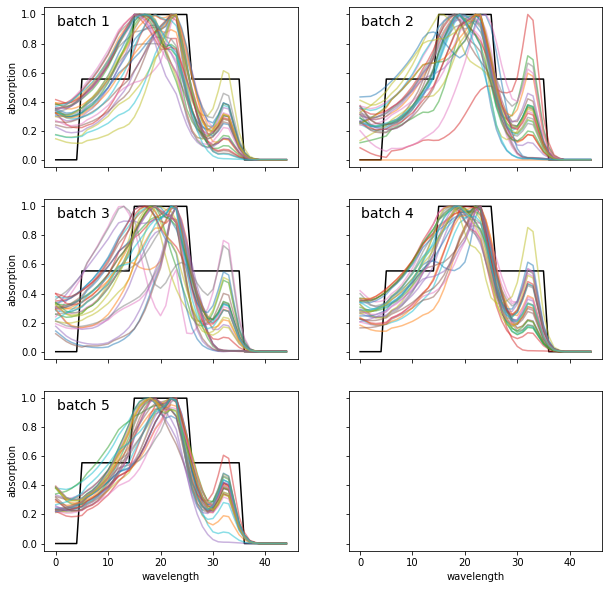

In [10]:
data = agent.X

fig, axs = plt.subplots(nrows=epochs//2+1, ncols=2, figsize=(10, 10), sharex=True, sharey=True)
axs=axs.flatten()
for i in range(epochs):
    #plt.figure()
    axs[i].plot(min_max(target_spectra), color='black', label='target')
    textstr=f"batch {i+1}"
    axs[i].text(0.05, 0.95, textstr, transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top')
    for j in range(batch_size):
        spec = spectra_from_conc(data[i*batch_size + j], dyes)
        axs[i].plot(spec, alpha=.5)
    
plt.setp(axs[[-2,-1]], xlabel='wavelength')
plt.setp(axs[::2], ylabel='absorption')

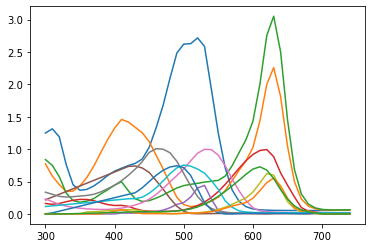

In [8]:
plt.figure()
plt.plot(wavelength, RED)
plt.plot(wavelength, GREEN)
plt.plot(wavelength, BLUE)
plt.plot(wavelength, SKY_BLUE)
plt.plot(wavelength, ERYTHROSINE)
plt.plot(wavelength, TATRIZINE)
plt.plot(wavelength, BERRY)


plt.plot(wavelength, SUNFLOWER)
plt.plot(wavelength, FAST_GREEN)

plt.plot(wavelength, ALLURA_RED)

plt.plot(wavelength, SUNSET_YELLOW)
plt.plot(wavelength, BRILLIANT_BLUE)
plt.plot(wavelength, INDIGO_CARMINE)